# Half-Cheetah with Cyclic Gait Reward 🔄

**This version adds your excellent idea: rewarding periodic/cyclic motion!**

**New features:**
- ✅ Multi-period cyclic reward (encourages repeating gait patterns)
- ✅ Smooth motion (increased control cost + smoothness penalty)
- ✅ All previous improvements

**Expected results:**
- Natural, repeating gait cycles
- Even smoother motion
- More efficient locomotion

In [35]:
import os
os.environ["MUJOCO_GL"] = "glfw"   # try glfw first on mac
try:
    import mujoco
    print("mujoco imported OK, MUJOCO_GL =", os.environ.get("MUJOCO_GL"))
except Exception as e:
    print("import failed:", e)

!pip install gymnasium stable-baselines3 shimmy mediapy mujoco -q

mujoco imported OK, MUJOCO_GL = glfw


In [36]:
import gymnasium as gym
import numpy as np
import shutil
# import mujoco
import mediapy as media
from stable_baselines3 import PPO
from gymnasium import spaces
import matplotlib.pyplot as plt
from IPython.display import HTML

## Environment with Cyclic Gait Reward

**Key innovation: Multi-Period Cyclic Reward**

The environment now:
1. Tracks recent action history
2. Compares current actions to actions from N steps ago (where N = 10, 15, 20, or 25)
3. Rewards actions that match previous patterns → encourages cyclic motion!

This naturally creates smoother, more realistic walking gaits.

In [41]:
class CyclicCheetahEnv(gym.Env):
    metadata = {"render_modes": ["rgb_array"]}

    def __init__(self, render_mode="rgb_array"):
        super(CyclicCheetahEnv, self).__init__()

        self.xml = """
          <mujoco model="cheetah">
            <compiler angle="radian" coordinate="local" inertiafromgeom="true" settotalmass="14"/>
            <default>
              <joint armature=".1" damping=".01" limited="true" solimplimit="0 .8 .03" solreflimit=".02 1" stiffness="8"/>
              <geom conaffinity="0" condim="3" contype="1" friction=".4 .1 .1" rgba="0.8 0.6 .4 1" solimp="0.0 0.8 0.01" solref="0.02 1"/>
              <motor ctrllimited="true" ctrlrange="-1 1"/>
            </default>
            <size nstack="300000" nuser_geom="1"/>
            <option gravity="0 0 -9.81" timestep="0.01"/>
            <asset>
              <texture builtin="gradient" height="100" rgb1="1 1 1" rgb2="0 0 0" type="skybox" width="100"/>
              <texture builtin="flat" height="1278" mark="cross" markrgb="1 1 1" name="texgeom" random="0.01" rgb1="0.8 0.6 0.4" rgb2="0.8 0.6 0.4" type="cube" width="127"/>
              <texture builtin="checker" height="100" name="texplane" rgb1="0 0 0" rgb2="0.8 0.8 0.8" type="2d" width="100"/>
              <material name="MatPlane" reflectance="0.5" shininess="1" specular="1" texrepeat="60 60" texture="texplane"/>
              <material name="geom" texture="texgeom" texuniform="true"/>
            </asset>
            <worldbody>
              <light cutoff="100" diffuse="1 1 1" dir="-0 0 -1.3" directional="true" exponent="1" pos="0 0 1.3" specular=".1 .1 .1"/>
              <geom conaffinity="1" condim="3" material="MatPlane" name="floor" pos="0 0 0" rgba="0.8 0.9 0.8 1" size="40 40 40" type="plane"/>
              <body name="torso" pos="0 0 .7">
                <camera name="track" mode="trackcom" pos="0 -3 0.3" xyaxes="1 0 0 0 0 1"/>
                <joint armature="0" axis="1 0 0" damping="0" limited="false" name="rootx" pos="0 0 0" stiffness="0" type="slide"/>
                <joint armature="0" axis="0 0 1" damping="0" limited="false" name="rootz" pos="0 0 0" stiffness="0" type="slide"/>
                <joint armature="0" axis="0 1 0" damping="0" limited="false" name="rooty" pos="0 0 0" stiffness="0" type="hinge"/>
                <geom fromto="-.5 0 0 .5 0 0" name="torso" size="0.046" type="capsule"/>
                <geom axisangle="0 1 0 .87" name="head" pos=".6 0 .1" size="0.046 .15" type="capsule"/>
                <!-- <site name='tip'  pos='.15 0 .11'/>-->
                <body name="bthigh" pos="-.5 0 0">
                  <joint axis="0 1 0" damping="6" name="bthigh" pos="0 0 0" range="-.52 1.05" stiffness="240" type="hinge"/>
                  <geom axisangle="0 1 0 -3.8" name="bthigh" pos=".1 0 -.13" size="0.046 .145" type="capsule"/>
                  <body name="bshin" pos=".16 0 -.25">
                    <joint axis="0 1 0" damping="4.5" name="bshin" pos="0 0 0" range="-.785 .785" stiffness="180" type="hinge"/>
                    <geom axisangle="0 1 0 -2.03" name="bshin" pos="-.14 0 -.07" rgba="0.9 0.6 0.6 1" size="0.046 .15" type="capsule"/>
                    <body name="bfoot" pos="-.28 0 -.14">
                      <joint axis="0 1 0" damping="3" name="bfoot" pos="0 0 0" range="-.4 .785" stiffness="120" type="hinge"/>
                      <geom axisangle="0 1 0 -.27" name="bfoot" pos=".03 0 -.097" rgba="0.9 0.6 0.6 1" size="0.046 .094" type="capsule"/>
                    </body>
                  </body>
                </body>
                <body name="fthigh" pos=".5 0 0">
                  <joint axis="0 1 0" damping="4.5" name="fthigh" pos="0 0 0" range="-1 .7" stiffness="180" type="hinge"/>
                  <geom axisangle="0 1 0 .52" name="fthigh" pos="-.07 0 -.12" size="0.046 .133" type="capsule"/>
                  <body name="fshin" pos="-.14 0 -.24">
                    <joint axis="0 1 0" damping="3" name="fshin" pos="0 0 0" range="-1.2 .87" stiffness="120" type="hinge"/>
                    <geom axisangle="0 1 0 -.6" name="fshin" pos=".065 0 -.09" rgba="0.9 0.6 0.6 1" size="0.046 .106" type="capsule"/>
                    <body name="ffoot" pos=".13 0 -.18">
                      <joint axis="0 1 0" damping="1.5" name="ffoot" pos="0 0 0" range="-.5 .5" stiffness="60" type="hinge"/>
                      <geom axisangle="0 1 0 -.6" name="ffoot" pos=".045 0 -.07" rgba="0.9 0.6 0.6 1" size="0.046 .07" type="capsule"/>
                    </body>
                  </body>
                </body>
              </body>
            </worldbody>
            <actuator>
              <motor gear="120" joint="bthigh" name="bthigh"/>
              <motor gear="90" joint="bshin" name="bshin"/>
              <motor gear="60" joint="bfoot" name="bfoot"/>
              <motor gear="120" joint="fthigh" name="fthigh"/>
              <motor gear="60" joint="fshin" name="fshin"/>
              <motor gear="30" joint="ffoot" name="ffoot"/>
            </actuator>
          </mujoco>

        """

        self.model = mujoco.MjModel.from_xml_string(self.xml)
        self.data = mujoco.MjData(self.model)
        self.renderer = mujoco.Renderer(self.model, height=480, width=640)

        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(6,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(17,), dtype=np.float32)
        self.render_mode = render_mode

        # Body IDs
        self.bfoot_body_id = mujoco.mj_name2id(self.model, mujoco.mjtObj.mjOBJ_BODY, "bfoot")
        self.ffoot_body_id = mujoco.mj_name2id(self.model, mujoco.mjtObj.mjOBJ_BODY, "ffoot")
        self.torso_body_id = mujoco.mj_name2id(self.model, mujoco.mjtObj.mjOBJ_BODY, "torso")

        # Tracking
        self.prev_x_pos = 0.0
        self.prev_action = np.zeros(6)

        # === CYCLIC GAIT TRACKING ===
        self.periods = [10, 15, 20, 25]  # Try multiple gait periods
        self.action_history = []
        self.max_history = 50

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        mujoco.mj_resetData(self.model, self.data)

        self.data.qpos[0] = 0.0
        self.data.qpos[1] = 0.0
        self.data.qpos[2] = 0.0
        self.data.qpos[3:] += np.random.uniform(-0.05, 0.05, size=6)
        self.data.qvel[:] = np.random.uniform(-0.1, 0.1, size=9)

        mujoco.mj_forward(self.model, self.data)

        self.prev_x_pos = self.data.qpos[0]
        self.prev_action = np.zeros(6)
        self.action_history = []  # Reset history

        return self._get_obs(), {}

    def step(self, action):
        action = np.clip(action, -1.0, 1.0)
        self.data.ctrl[:] = action

        for _ in range(5):
            mujoco.mj_step(self.model, self.data)

        # Get state
        x_pos = self.data.qpos[0]
        z_pos = self.data.qpos[1]
        pitch_angle = self.data.qpos[2]

        x_velocity = (x_pos - self.prev_x_pos) / (0.01 * 5)
        self.prev_x_pos = x_pos

        torso_height = self.data.xpos[self.torso_body_id][2]
        bfoot_z = self.data.xpos[self.bfoot_body_id][2]
        ffoot_z = self.data.xpos[self.ffoot_body_id][2]

        # Store action in history
        self.action_history.append(action.copy())
        if len(self.action_history) > self.max_history:
            self.action_history.pop(0)

        # ============ REWARD SHAPING ============

        # 1. Forward velocity
        reward_velocity = 1.0 * np.exp(- (x_velocity - 2.5) ** 2 / 1)

        # 2. Posture
        reward_posture = -0.5 * (pitch_angle ** 2)

        # 3. Height maintenance
        target_height = 0.7
        height_deviation = abs(torso_height - target_height)
        reward_height = -1.0 * height_deviation

        # 4. Gait
        max_foot_height = max(bfoot_z, ffoot_z)
        foot_lift = max(0, max_foot_height - 0.05)
        foot_lift_capped = min(foot_lift, 0.15)  # Cap it!
        reward_gait = 0.75 * foot_lift_capped

        # 5. Control cost
        reward_ctrl = -0.15 * np.sum(np.square(action))

        # 6. Action smoothness
        action_change = np.sum(np.square(action - self.prev_action))
        reward_smoothness = -0.10 * action_change
        self.prev_action = action.copy()

        # 7. === CYCLIC REWARD (YOUR IDEA!) ===
        reward_cyclic = 0.0
        best_similarity = 0.0

        if len(self.action_history) > max(self.periods):
            similarities = []

            for period in self.periods:
                if len(self.action_history) >= period:
                    # Compare current action to action from 'period' steps ago
                    past_action = self.action_history[-period]

                    # Calculate how similar they are
                    diff = np.sum(np.square(action - past_action))
                    similarity = 1.0 / (1.0 + diff)  # Closer to 1 = more similar
                    similarities.append(similarity)

            if similarities:
                # Reward the BEST matching period
                best_similarity = max(similarities)
                reward_cyclic = 0.10 * best_similarity

        # 8. Survival
        is_healthy = (torso_height > 0.3) and (abs(pitch_angle) < 1.0)
        reward_survival = 1.0 if is_healthy else 0.0

        # Total reward (now includes cyclic!)
        reward = (reward_velocity + reward_posture + reward_height +
                 reward_gait + reward_ctrl + reward_smoothness +
                 reward_cyclic + reward_survival)

        terminated = not is_healthy

        info = {
            'x_velocity': x_velocity,
            'torso_height': torso_height,
            'pitch_angle': pitch_angle,
            'action_change': action_change,
            'reward_cyclic': reward_cyclic,
            'gait_periodicity': best_similarity,  # Track how periodic the motion is
        }

        return self._get_obs(), reward, terminated, False, info

    def _get_obs(self):
        return np.concatenate([self.data.qpos.flat[1:], self.data.qvel.flat]).astype(np.float32)

    def render(self):
        if self.render_mode == "rgb_array":
            self.renderer.update_scene(self.data, camera="track")
            return self.renderer.render()

## Training

In [42]:
env = CyclicCheetahEnv()

policy_kwargs = dict(
    net_arch=[256, 256],
)

model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    device="auto",
    policy_kwargs=policy_kwargs,
    learning_rate=2e-4,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.15,
    ent_coef=0.005,
)

print("\n" + "="*60)
print("Training Cyclic Gait Agent")
print("="*60)
print("Reward components:")
print("  ✓ Velocity (1.0)")
print("  ✓ Posture (-0.5)")
print("  ✓ Height (-1.0)")
print("  ✓ Gait (0.5)")
print("  ✓ Control cost (-0.15)")
print("  ✓ Smoothness (-0.10)")
print("  ✓ CYCLIC (0.10) <-- NEW! Your idea!")
print("  ✓ Survival (1.0)")
print("="*60)
print("\nThe cyclic reward will encourage repeating gait patterns!")
print("Training will take ~20 minutes...\n")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

Training Cyclic Gait Agent
Reward components:
  ✓ Velocity (1.0)
  ✓ Posture (-0.5)
  ✓ Height (-1.0)
  ✓ Gait (0.5)
  ✓ Control cost (-0.15)
  ✓ Smoothness (-0.10)
  ✓ CYCLIC (0.10) <-- NEW! Your idea!
  ✓ Survival (1.0)

The cyclic reward will encourage repeating gait patterns!
Training will take ~20 minutes...



Wrapping the env in a DummyVecEnv.
Starting training for 800000 timesteps. Monitor logs -> rl_logs/monitor.csv
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 236      |
|    ep_rew_mean     | -10.2    |
| time/              |          |
|    fps             | 6557     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 236      |
|    ep_rew_mean     | -10.2    |
| time/              |          |
|    fps             | 6557     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 202          |
|    ep_rew_mean          | -6.01        |
| time/                   |          

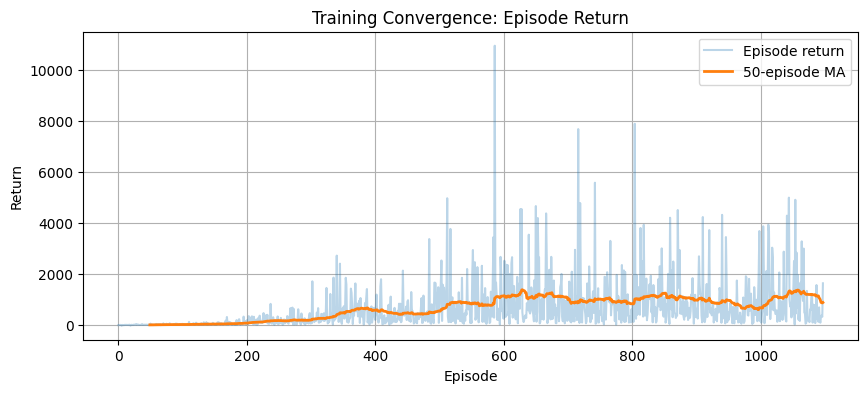

Plotted 1098 episodes (smoothed window=50).


In [43]:
# Train with integrated reward logging (writes Monitor file and plots returns afterwards)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3.common.monitor import Monitor

# Ensure a log directory
log_dir = "rl_logs"
os.makedirs(log_dir, exist_ok=True)
monitor_file = os.path.join(log_dir, "monitor.csv")

# Ensure env exists (created in the previous cell). If not, recreate it.
try:
    env
except NameError:
    env = CyclicCheetahEnv()

# Wrap environment with Monitor to record episode returns
env = Monitor(env, filename=monitor_file, allow_early_resets=True)

# Attach the monitored env to the model (model was created earlier)
try:
    model.set_env(env)
except Exception:
    # If model isn't defined, recreate it with same hyperparams
    policy_kwargs = dict(net_arch=[256, 256])
    model = PPO(
        "MlpPolicy",
        env,
        verbose=1,
        device="auto",
        policy_kwargs=policy_kwargs,
        learning_rate=2e-4,
        n_steps=2048,
        batch_size=64,
        n_epochs=10,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.15,
        ent_coef=0.005,
    )

# Train (this may take long). Change total_timesteps for quick tests.
total_timesteps = 800_000
print(f"Starting training for {total_timesteps} timesteps. Monitor logs -> {monitor_file}")
model.learn(total_timesteps=total_timesteps)
print("\nTraining Complete!")

# After training, load the Monitor CSV and plot episode returns
if os.path.exists(monitor_file):
    mon = pd.read_csv(monitor_file, comment='#', header=None)

    # Robust numeric conversion: coerce non-numeric entries to NaN and pick first valid column
    mon_numeric = mon.apply(pd.to_numeric, errors='coerce')
    valid_cols = [c for c in mon_numeric.columns if mon_numeric[c].notna().any()]
    if valid_cols:
        rewards = mon_numeric[valid_cols[0]].dropna().values.astype(float)
    else:
        # Flatten and try to parse any numeric tokens
        flat = pd.to_numeric(mon.values.ravel(), errors='coerce')
        rewards = flat[~np.isnan(flat)].astype(float)

    if rewards.size == 0:
        print("No numeric rewards found in monitor file; cannot plot convergence.")
    else:
        # Plot raw episode returns and smoothed moving average
        window = 50
        if len(rewards) < window:
            window = max(1, int(len(rewards) * 0.2))
        if window < 1:
            window = 1
        if len(rewards) >= window:
            smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
        else:
            smoothed = rewards

        plt.figure(figsize=(10,4))
        plt.plot(rewards, alpha=0.3, label='Episode return')
        if smoothed is not None and len(smoothed) > 0:
            plt.plot(np.arange(window-1, window-1+len(smoothed)), smoothed, color='C1', linewidth=2, label=f'{window}-episode MA')
        plt.xlabel('Episode')
        plt.ylabel('Return')
        plt.title('Training Convergence: Episode Return')
        plt.legend()
        plt.grid(True)
        plt.show()

        print(f"Plotted {len(rewards)} episodes (smoothed window={window}).")
else:
    print("Monitor log not found; no convergence plot produced.")

## Visualization & Analysis

Let's see if the cyclic reward created a natural, repeating gait!

In [44]:
print("Generating video and collecting metrics...")
obs, _ = env.reset()
frames = []

# Collect detailed metrics
velocities = []
periodicities = []
action_changes = []
action_trace = [[] for _ in range(6)]  # Track each joint separately

for i in range(500):
    frames.append(env.render())
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)

    velocities.append(info['x_velocity'])
    periodicities.append(info['gait_periodicity'])
    action_changes.append(info['action_change'])

    # Track each joint's action
    for j in range(6):
        action_trace[j].append(action[j])

    if terminated:
        print(f"Episode ended at frame {i}")
        obs, _ = env.reset()

print(f"\n{'='*60}")
print("Performance Metrics:")
print(f"{'='*60}")
print(f"Average velocity:      {np.mean(velocities):.3f} m/s")
print(f"Average periodicity:   {np.mean(periodicities):.3f}")
print(f"  (Higher is better - 0.5+ means clear cyclic pattern)")
print(f"Average action change: {np.mean(action_changes):.4f}")
print(f"  (Lower is smoother - <0.2 is excellent)")
print(f"{'='*60}\n")

media.show_video(frames, fps=30)

Generating video and collecting metrics...

Performance Metrics:
Average velocity:      2.148 m/s
Average periodicity:   0.618
  (Higher is better - 0.5+ means clear cyclic pattern)
Average action change: 1.1581
  (Lower is smoother - <0.2 is excellent)


Performance Metrics:
Average velocity:      2.148 m/s
Average periodicity:   0.618
  (Higher is better - 0.5+ means clear cyclic pattern)
Average action change: 1.1581
  (Lower is smoother - <0.2 is excellent)



## Gait Analysis: Visualize the Cyclic Pattern

Let's plot the joint actions over time to see if they're periodic!

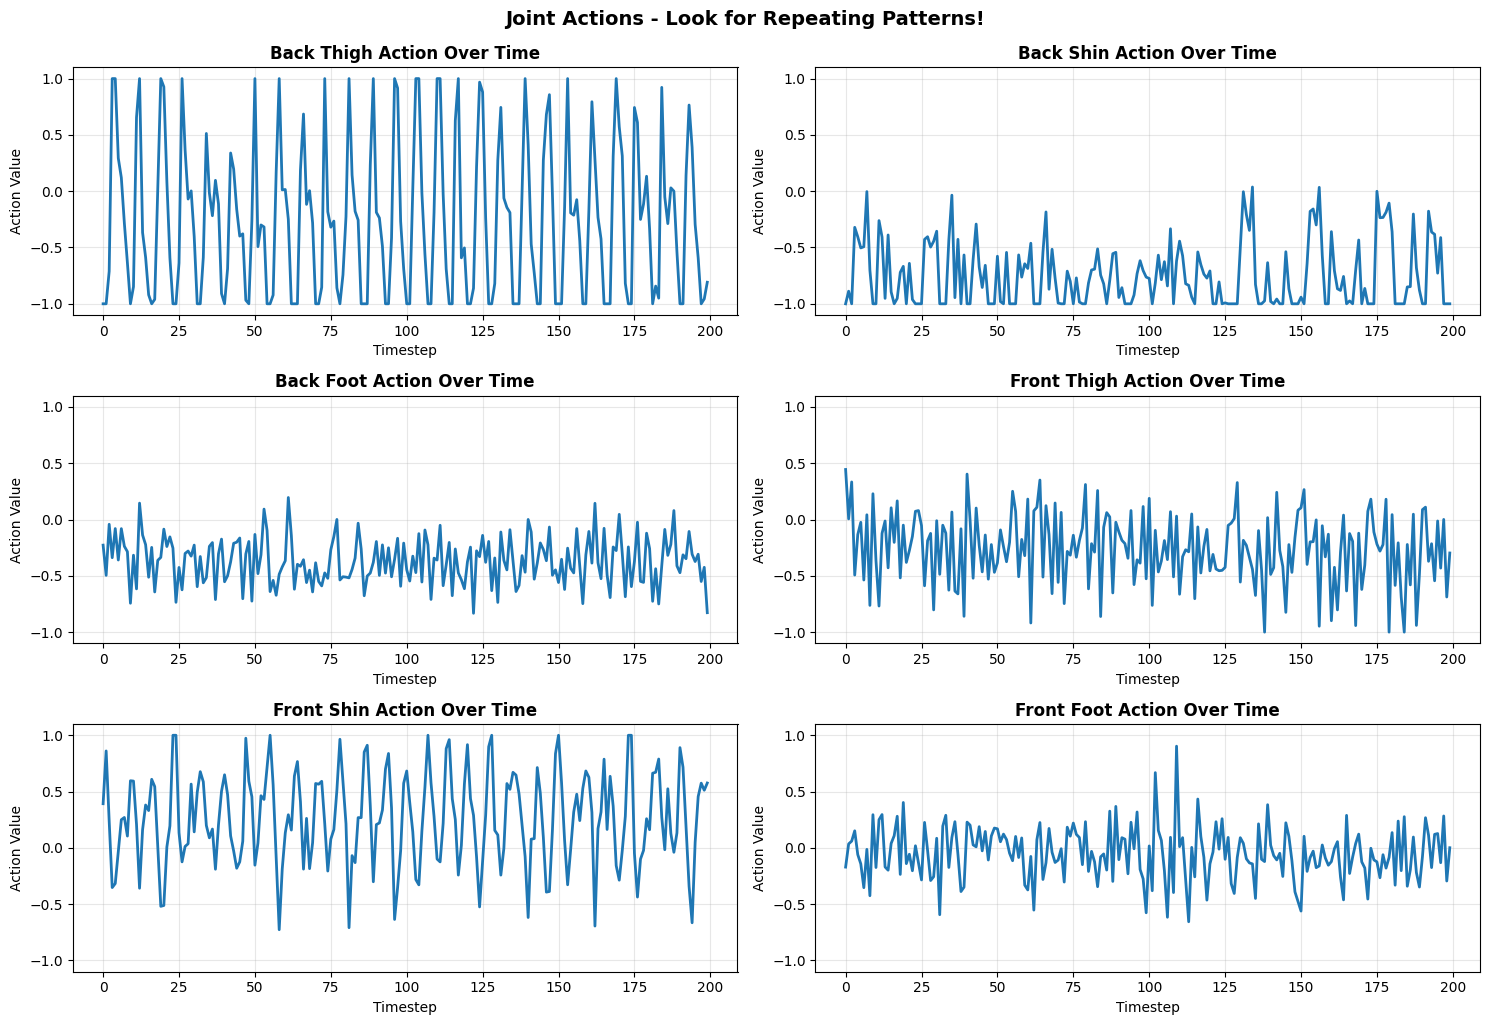


📊 Analysis:
Look for:
  ✓ Repeating wave patterns = Cyclic gait working!
  ✓ Similar peaks/valleys = Natural rhythm
  ✗ Random noise = Not periodic yet


In [ ]:
joint_names = ['Back Thigh', 'Back Shin', 'Back Foot', 'Front Thigh', 'Front Shin', 'Front Foot']

fig, axes = plt.subplots(3, 2, figsize=(15, 10))
axes = axes.flatten()

for i in range(6):
    axes[i].plot(action_trace[i][:200], linewidth=2)  # Plot first 200 steps
    axes[i].set_title(f'{joint_names[i]} Action Over Time', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Timestep')
    axes[i].set_ylabel('Action Value')
    axes[i].grid(True, alpha=0.3)
    axes[i].set_ylim(-1.1, 1.1)

plt.tight_layout()
plt.suptitle('Joint Actions - Look for Repeating Patterns!', fontsize=14, fontweight='bold', y=1.02)
plt.show()

print("\n📊 Analysis:")
print("Look for:")
print("  ✓ Repeating wave patterns = Cyclic gait working!")
print("  ✓ Similar peaks/valleys = Natural rhythm")
print("  ✗ Random noise = Not periodic yet")

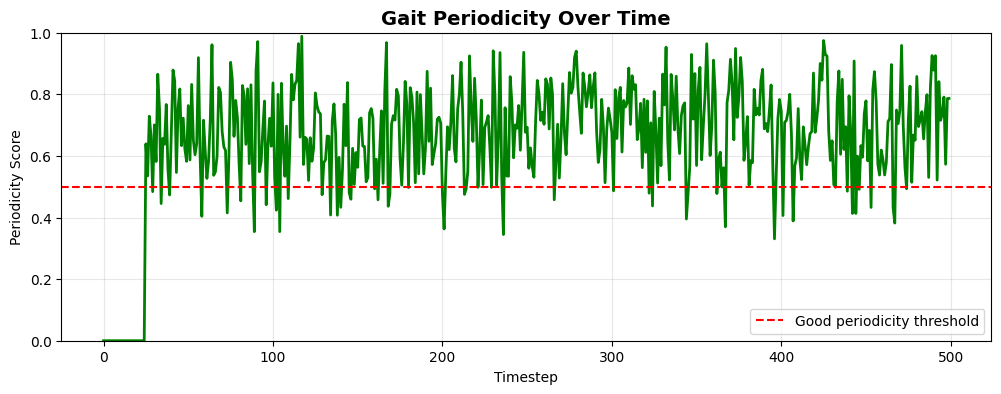


📈 Periodicity Statistics:
Average: 0.651
Maximum: 0.989
% above 0.5: 85.0%


In [ ]:
# Plot periodicity score over time
plt.figure(figsize=(12, 4))
plt.plot(periodicities, linewidth=2, color='green')
plt.axhline(y=0.5, color='r', linestyle='--', label='Good periodicity threshold')
plt.title('Gait Periodicity Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Timestep')
plt.ylabel('Periodicity Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.show()

print(f"\n📈 Periodicity Statistics:")
print(f"Average: {np.mean(periodicities):.3f}")
print(f"Maximum: {np.max(periodicities):.3f}")
print(f"% above 0.5: {100 * np.mean(np.array(periodicities) > 0.5):.1f}%")

In [ ]:
# Optional: Save the model
model.save("cyclic_cheetah_ppo")
print("Model saved!")

Model saved!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

## Summary

### Your Cyclic Reward Idea:

**Concept**: Real walking is periodic - encourage the robot to repeat its actions!

**Implementation**:
- Track last 50 actions
- Compare current action to actions from 10, 15, 20, 25 steps ago
- Reward similarity → encourages cyclic patterns

**Expected Benefits**:
1. ✅ Natural, repeating gait
2. ✅ Smoother motion (cycles are naturally smooth)
3. ✅ More efficient (periodic = less wasted energy)
4. ✅ More realistic (like real animals)

### Interpreting Results:

**Good signs**:
- Periodicity score > 0.5 → Clear cyclic pattern!
- Smooth sine-like waves in action plots → Natural rhythm
- Consistent velocity → Stable gait

**If not very periodic yet**:
- Increase cyclic reward weight (0.10 → 0.15)
- Train longer (1M+ timesteps)
- Try different periods: `self.periods = [12, 18, 24]`

### Next Steps:

If this works well, you could try:
1. **Phase-based rewards** - reward proper timing between legs
2. **Frequency analysis** - use FFT to detect optimal period automatically
3. **Symmetry rewards** - ensure left-right or front-back symmetry

---

**Great idea!** This is exactly the kind of insight that leads to state-of-the-art locomotion! 🚀